# Exercise 3: Point Clouds From The KITTI Dataset

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
from kitti_utils import Kitti

First, let's load the data (images and point clouds from the KITTI dataset)

In [2]:
dataset = Kitti('./kitti', split='training')
data_idx = 0
pc_velo = dataset.get_lidar(data_idx)
calib = dataset.get_calibration(data_idx)
img = dataset.get_image(data_idx)
img_height, img_width, _ = img.shape

Run the code below to view a sample RGB image from the dataset

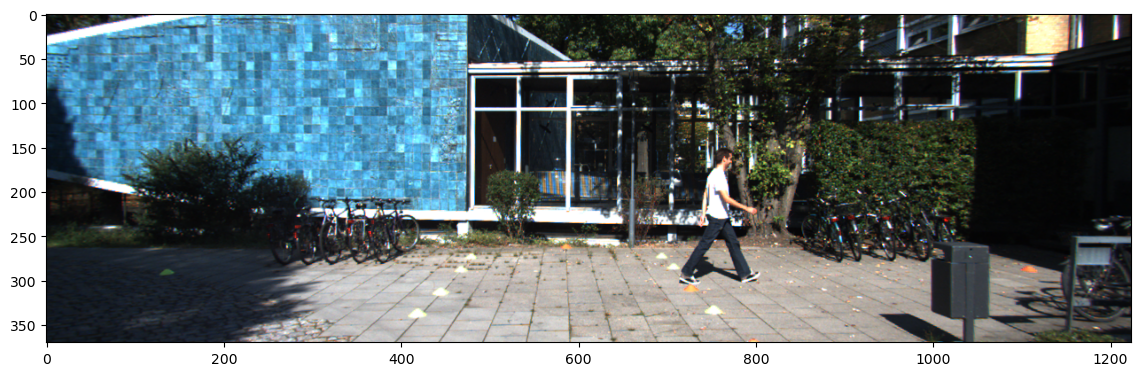

In [3]:
# Show RGB image
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig_rgb = plt.figure(figsize=(14, 7))
ax_rgb = fig_rgb.subplots()
ax_rgb.imshow(img)
plt.show()

Now let's plot the 3D point cloud data, as well as the projection of the 3D data onto various planes.

In [4]:
axes_limits = [
    [-60, 60], # X axis range
    [-20, 40], # Y axis range
    [-4, 4]   # Z axis range
]
axes_str = ['X', 'Y', 'Z']

def draw_box(pyplot_axis, vertices, axes=[0, 1, 2], color='black'):
    """
    Draws a bounding 3D box in a pyplot axis.
    
    Parameters
    ----------
    pyplot_axis : Pyplot axis to draw in.
    vertices    : Array 8 box vertices containing x, y, z coordinates.
    axes        : Axes to use. Defaults to `[0, 1, 2]`, e.g. x, y and z axes.
    color       : Drawing color. Defaults to `black`.
    """
    vertices = vertices[axes, :]
    connections = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # Lower plane parallel to Z=0 plane
        [4, 5], [5, 6], [6, 7], [7, 4],  # Upper plane parallel to Z=0 plane
        [0, 4], [1, 5], [2, 6], [3, 7]   # Connections between upper and lower planes
    ]
    for connection in connections:
        pyplot_axis.plot(*vertices[:, connection], c=color, lw=0.5)

def display_frame(pc_velo, points=1, point_colors=None):
    """
    Draws 3D plot of the lidar point cloud data and point cloud projections to various planes.
    
    Parameters
    ----------
    pc_velo     : 3D point cloud data. 
    points      : Fraction of lidar points to use. 
    colors      : List of colors for each point. 
    """
    points_step = int(1. / points)
    point_size = 0.01 * (1. / points)
    velo_range = range(0, pc_velo.shape[0], points_step)
    velo_frame = pc_velo[velo_range, :]      
    def draw_point_cloud(ax, title, axes=[0, 1, 2], xlim3d=None, ylim3d=None, zlim3d=None, point_colors=None):
        """
        Convenient method for drawing various point cloud projections.
        """
        if point_colors == None:
            ax.scatter(*np.transpose(velo_frame[:, axes]), s=point_size, c=velo_frame[:, 3], cmap='gray')
        else:
            ax.scatter(*np.transpose(velo_frame[:, axes]), s=point_size, c=point_colors)
        ax.set_title(title)
        ax.set_xlabel('{} axis'.format(axes_str[axes[0]]))
        ax.set_ylabel('{} axis'.format(axes_str[axes[1]]))
        if len(axes) > 2:
            ax.set_xlim3d(*axes_limits[axes[0]])
            ax.set_ylim3d(*axes_limits[axes[1]])
            ax.set_zlim3d(*axes_limits[axes[2]])
            ax.set_zlabel('{} axis'.format(axes_str[axes[2]]))
        else:
            ax.set_xlim(*axes_limits[axes[0]])
            ax.set_ylim(*axes_limits[axes[1]])
        # User specified limits
        if xlim3d!=None:
            ax.set_xlim3d(xlim3d)
        if ylim3d!=None:
            ax.set_ylim3d(ylim3d)
        if zlim3d!=None:
            ax.set_zlim3d(zlim3d)
                        
    # Draw point cloud data as 3D plot
    f2 = plt.figure(figsize=(15, 8))
    ax2 = f2.add_subplot(111, projection='3d')                    
    draw_point_cloud(ax2, 'Velodyne scan', xlim3d=(-10,30), point_colors=point_colors)
    plt.show()
    
    # Draw point cloud data as plane projections
    f, ax3 = plt.subplots(3, 1, figsize=(15, 25))
    draw_point_cloud(
        ax3[0], 
        'Velodyne scan, XZ projection (Y = 0)', 
        axes=[0, 2], # X and Z axes
        point_colors=point_colors
    )
    draw_point_cloud(
        ax3[1], 
        'Velodyne scan, XY projection (Z = 0)', 
        axes=[0, 1], # X and Y axes
        point_colors=point_colors
    )
    draw_point_cloud(
        ax3[2], 
        'Velodyne scan, YZ projection (X = 0)', 
        axes=[1, 2], # Y and Z axes
        point_colors=point_colors
    )
    plt.show()

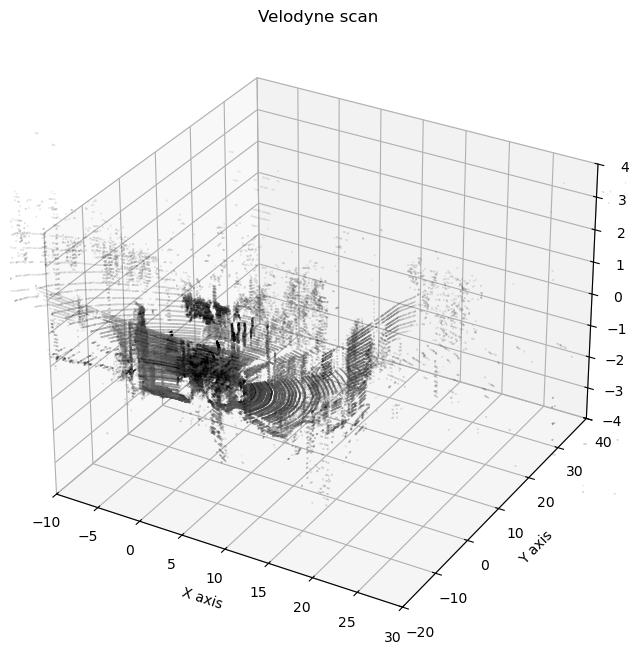

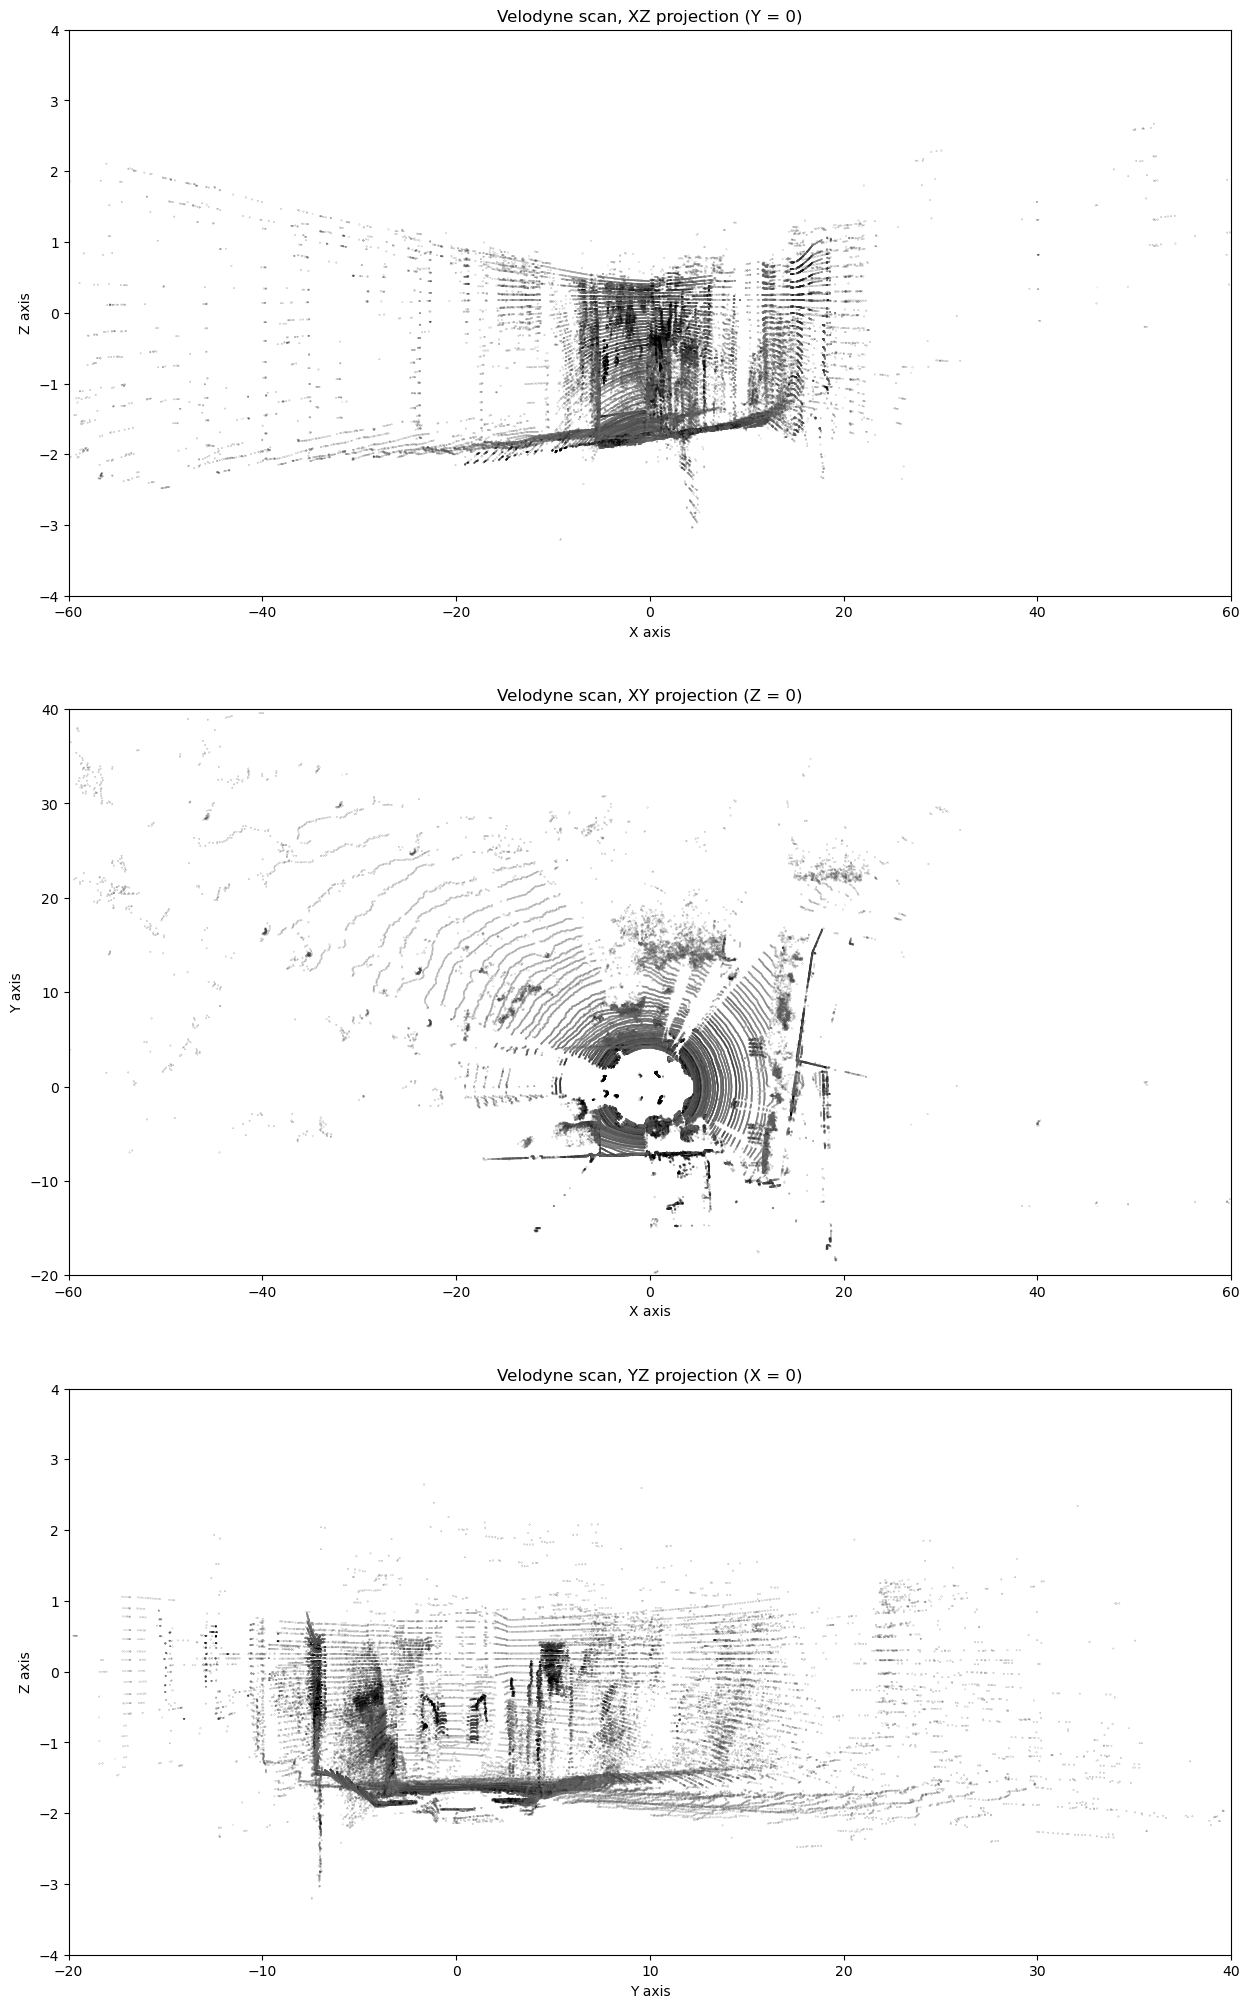

In [5]:
# Plot the point cloud data
display_frame(pc_velo)

Now we'll align the point cloud data with the RGB image data. 

In [6]:
def get_lidar_in_image_fov(
    pc_velo, calib, xmin, ymin, xmax, ymax, return_more=False, clip_distance=2.0
):
    """ Filter lidar points, keep those in image FOV """
    pts_2d = calib.project_velo_to_image(pc_velo)
    fov_inds = (
        (pts_2d[:, 0] < xmax)
        & (pts_2d[:, 0] >= xmin)
        & (pts_2d[:, 1] < ymax)
        & (pts_2d[:, 1] >= ymin)
    )
    fov_inds = fov_inds & (pc_velo[:, 0] > clip_distance)
    imgfov_pc_velo = pc_velo[fov_inds, :]
    if return_more:
        return imgfov_pc_velo, pts_2d, fov_inds
    else:
        return imgfov_pc_velo

In [7]:
# Project the 3D point cloud data into 2D and check which points are in the image FOV
# imgfov_pc_velo [n_subset, 3]: the subset of 3D points that are in the image FOV
# pts_2d [n, 3]: all of the 3D points projected into 2D
# fov_inds [n]: each element of fov_inds is true if the corresponding 3D point is in the image FOV, and false otherwise 
# imgfov_pts_2d [n_subset, 2]: the subset of 3D points that are in the image FOV, projected into 2D

imgfov_pc_velo, pts_2d, fov_inds = get_lidar_in_image_fov(pc_velo[:, 0:3], calib, 0, 0, img_width, img_height, True)
imgfov_pts_2d = pts_2d[fov_inds, :]

In [8]:
print('Total number of 3d points: ', len(pc_velo))
print('Number of 3d points in the image FOV: ', len(imgfov_pts_2d))

Total number of 3d points:  115384
Number of 3d points in the image FOV:  20285


In [9]:
# For the 3D points that are in the image FOV, get the corresponding image colors. 
# If the point is not in the image FOV, set the color to black.

import math

def rgb2hex(r,g,b):
    return "#{:02x}{:02x}{:02x}".format(r,g,b)
    
point_colors = ['#000000']*len(pc_velo)
for i in range(len(pc_velo)):
    if fov_inds[i] == True:
        x_coord = math.floor(pts_2d[i][0])
        y_coord = math.floor(pts_2d[i][1])
        rgb_color = img[y_coord, x_coord, :]
        color = rgb2hex(rgb_color[0], rgb_color[1], rgb_color[2])
        point_colors[i] = color        

Plot the 3D point cloud, coloring points with their corresponding RGB values 

Note that because most of the 3D points are outside of the image FOV, most of the points are black (there are 115384 3D point cloud points, and only 20285 are in the image FOV). However, we can distinctly see some elements of the RGB image here (e.g. the blue wall). 

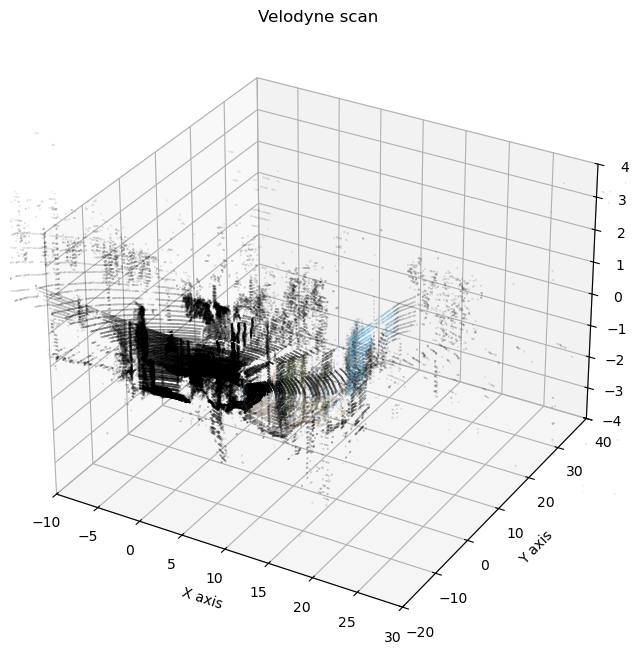

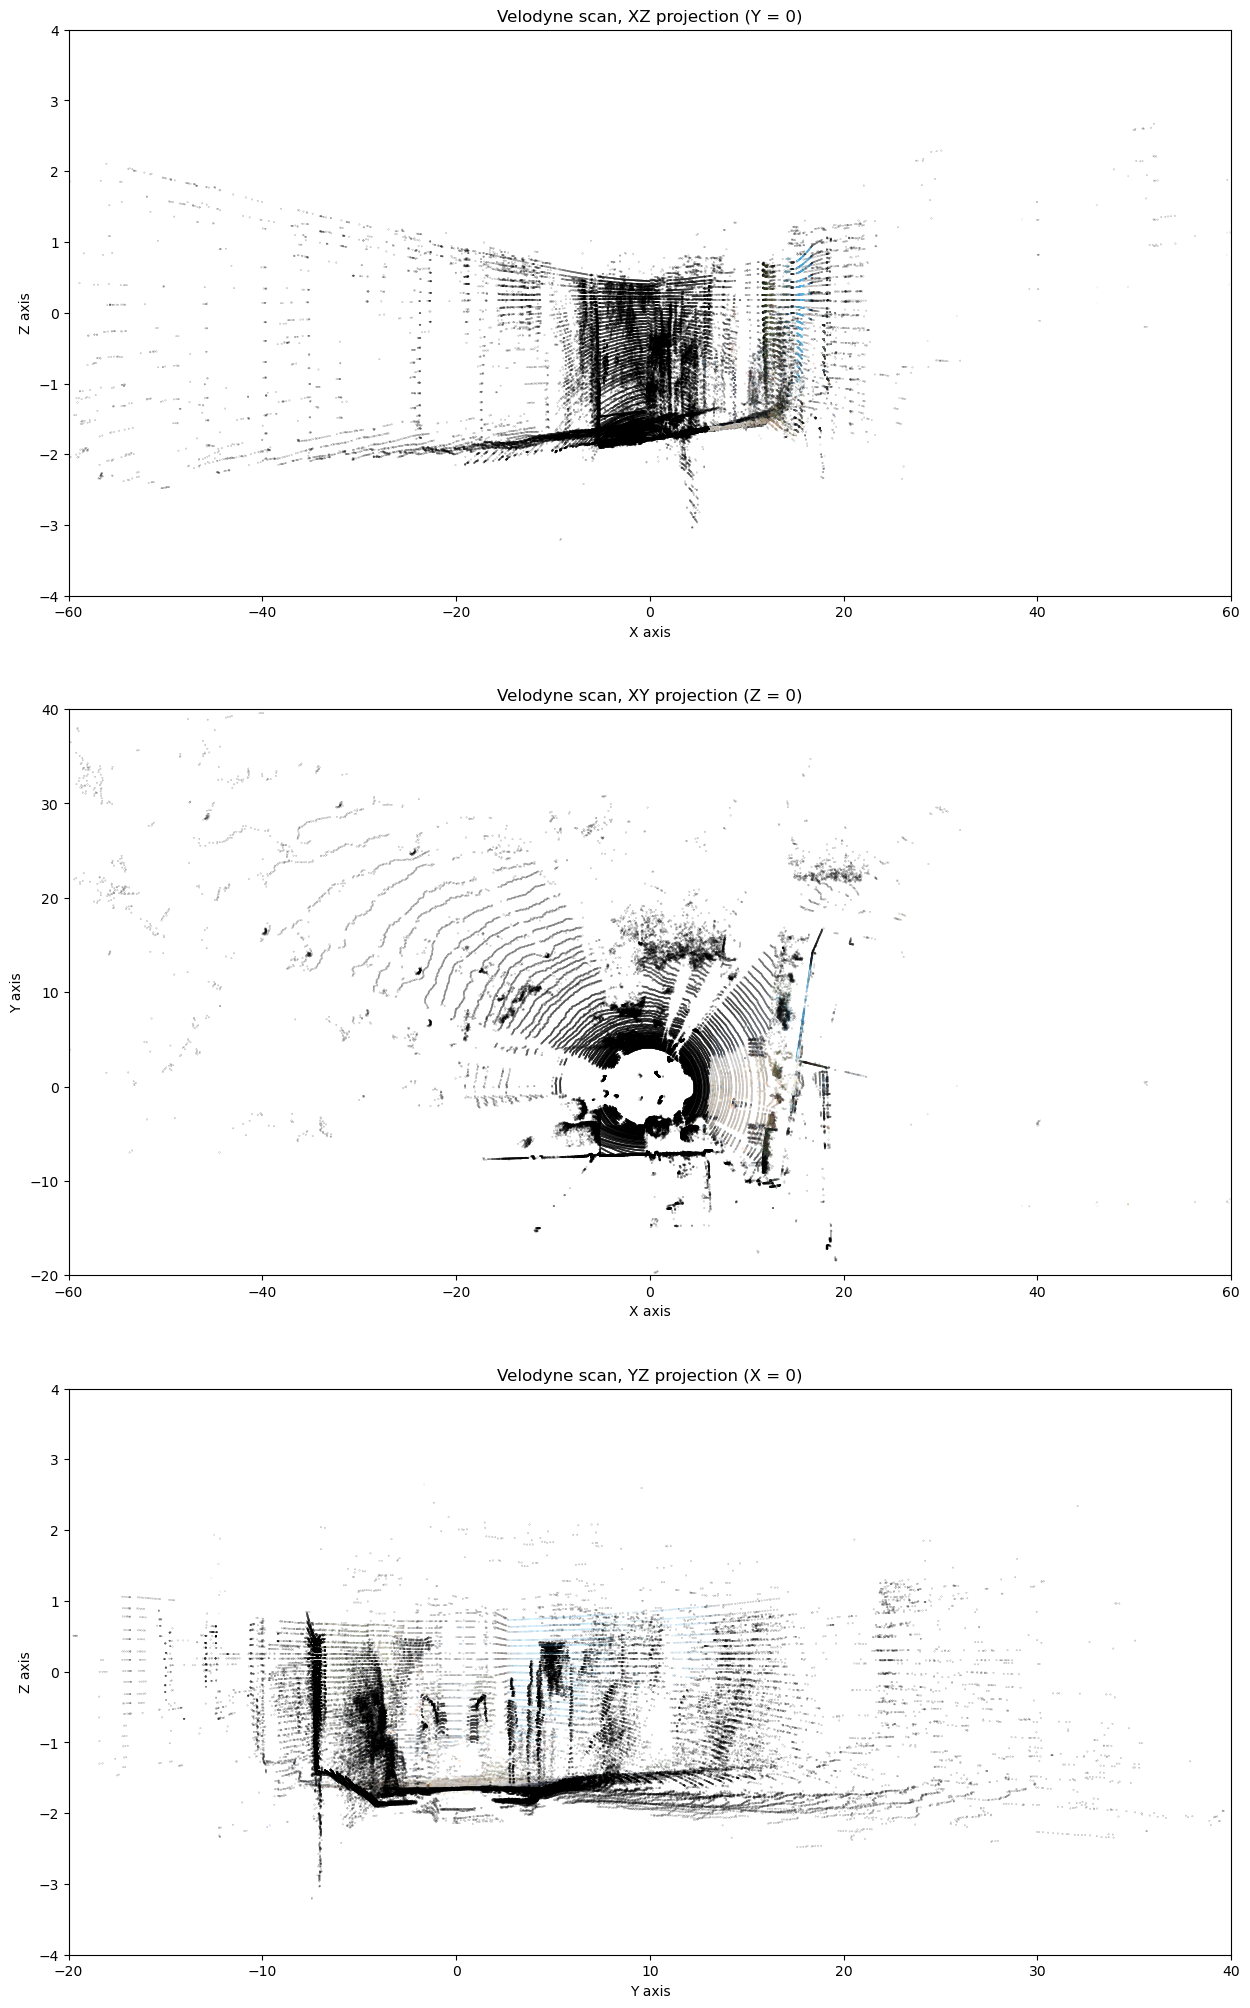

In [10]:
display_frame(pc_velo, point_colors=point_colors)

We can also plot just the subset of 3D points in the image FOV:

In [11]:
point_colors_subset = ['#000000']*len(imgfov_pc_velo)
for i in range(len(imgfov_pc_velo)):
    x_coord = math.floor(imgfov_pts_2d[i][0])
    y_coord = math.floor(imgfov_pts_2d[i][1])
    rgb_color = img[y_coord, x_coord, :]
    color = rgb2hex(rgb_color[0], rgb_color[1], rgb_color[2])
    point_colors_subset[i] = color

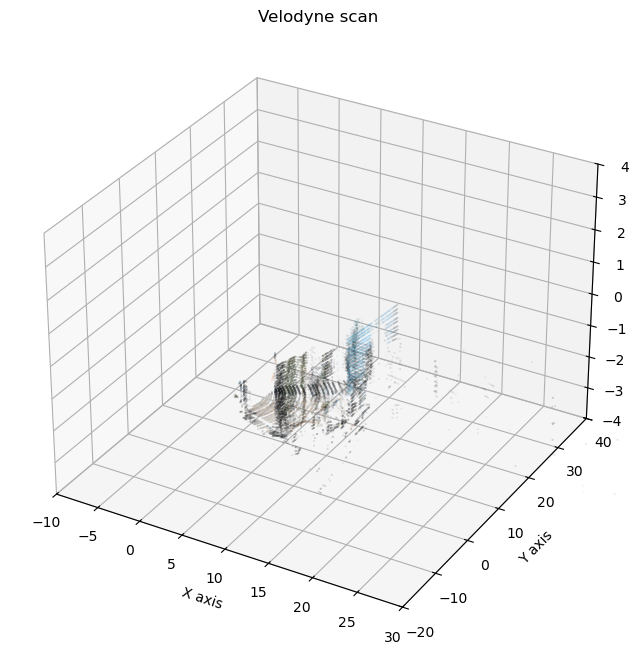

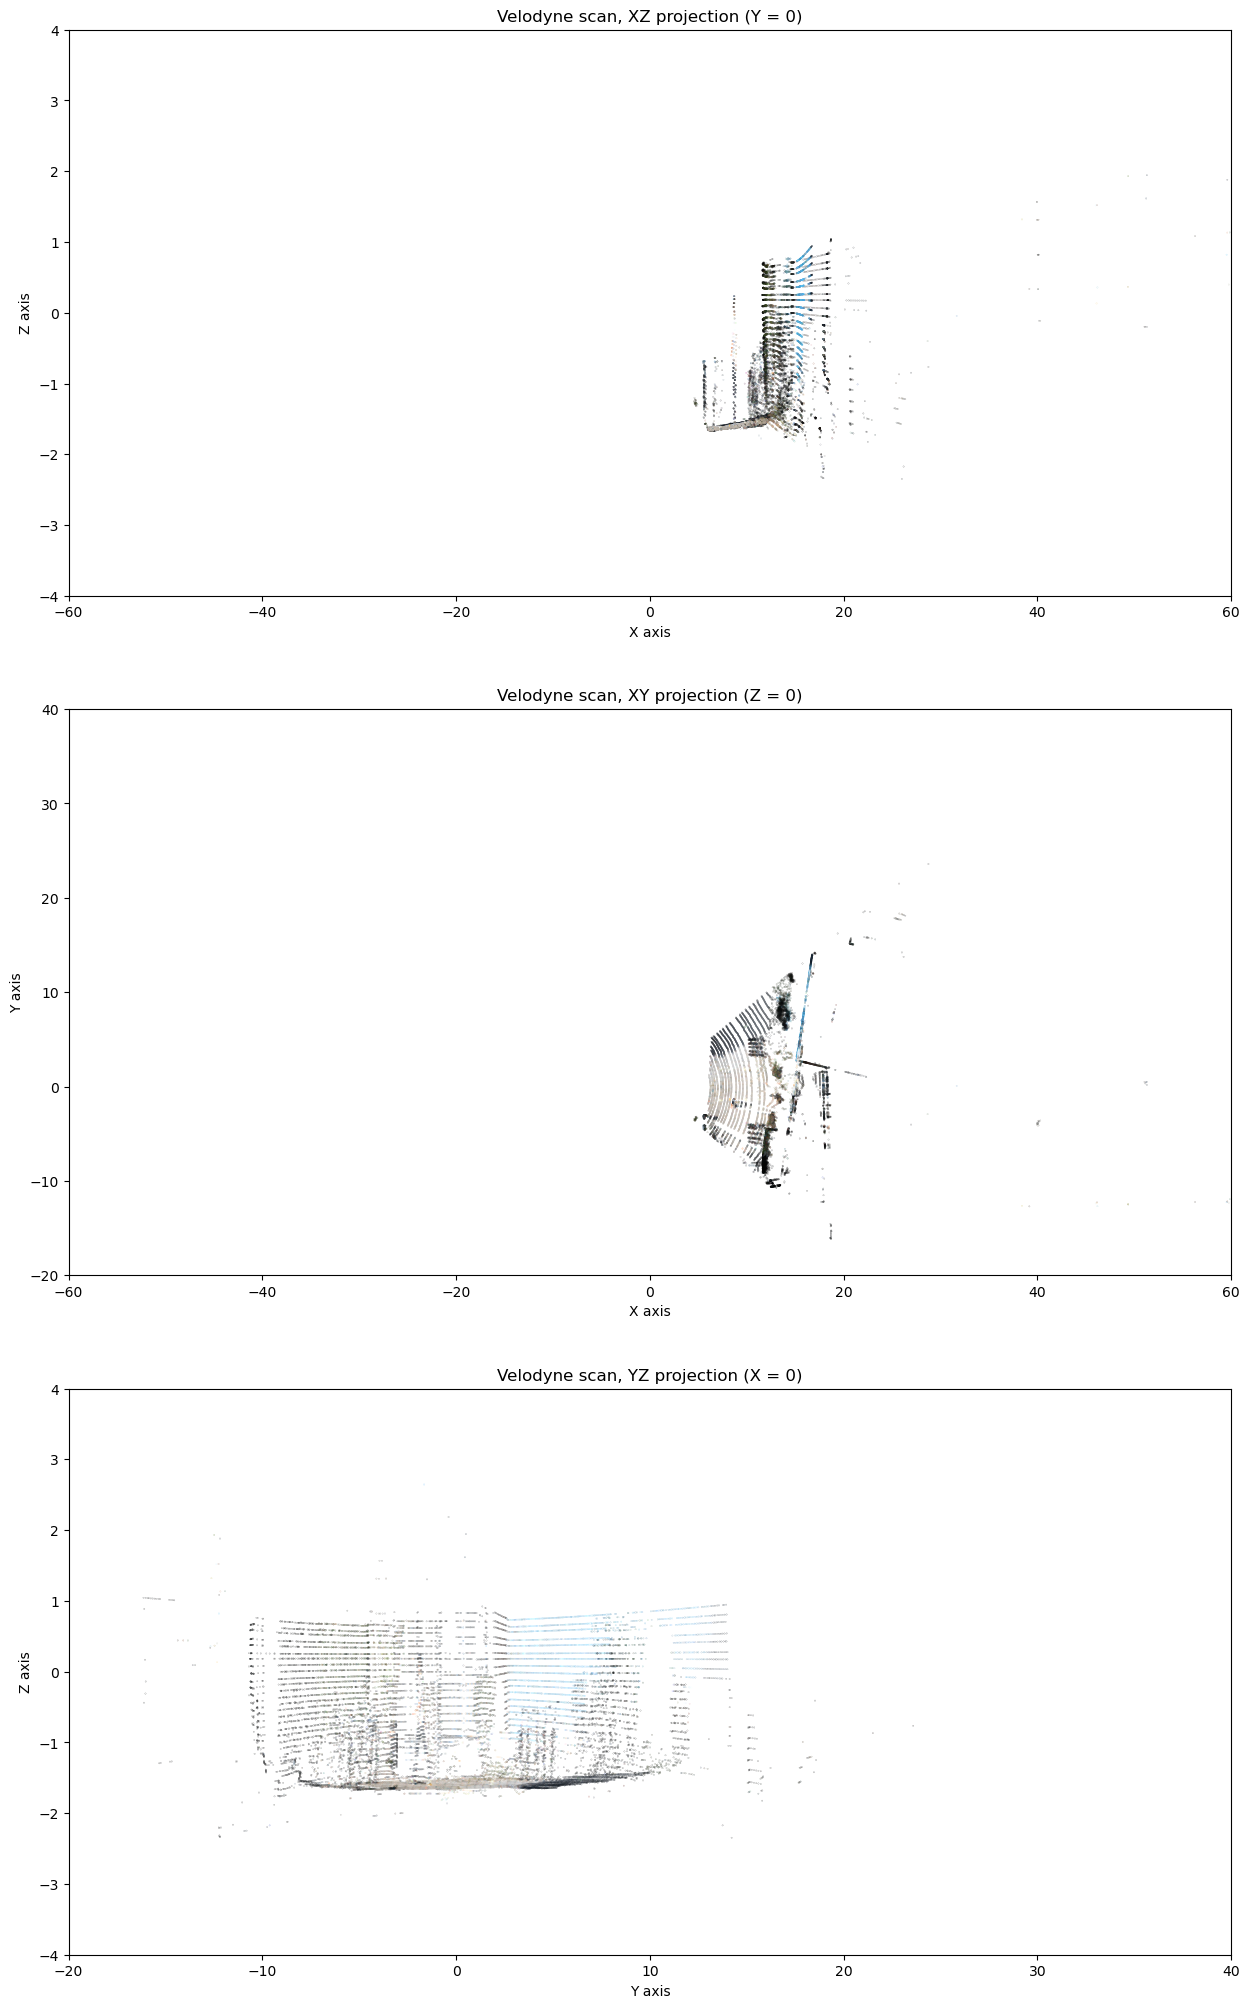

In [12]:
display_frame(imgfov_pc_velo, point_colors=point_colors_subset)